In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy
from scipy.sparse import csr_matrix

In [ ]:
movies_df =pd.read_csv(f'/content/drive/MyDrive/ml-1m/movies.dat',
                        delimiter='::', engine= 'python', header=None,
                        names=['movie_id','movie_name', 'genre'] , encoding='latin-1')
movies_df

,movie_id,movie_name,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [ ]:
readme_text = np.array(open(f'/content/drive/MyDrive/ml-1m/README').read().splitlines())
start_index = np.flatnonzero(np.core.defchararray.find(readme_text,'Occupation is chosen')!=-1)[0]
end_index = np.flatnonzero(np.core.defchararray.find(readme_text,'MOVIES FILE DESCRIPTION')!=-1)[0]
occupation_list = [x.split('"')[1] for x in readme_text[start_index:end_index][2:-1].tolist()]
occupation_dict = dict(zip(range(len(occupation_list)), occupation_list))


In [ ]:
users_df = pd.read_csv(f'/content/drive/MyDrive/ml-1m/users.dat',
                       delimiter='::', engine='python', header=None,
                       names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
users_df['occupation'] = users_df['occupation'].replace(occupation_dict)
users_df.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,K-12 student,48067
1,2,M,56,self-employed,70072
2,3,M,25,scientist,55117
3,4,M,45,executive/managerial,02460
4,5,M,25,writer,55455


In [ ]:
rating_df = pd.read_csv(f'/content/drive/MyDrive/ml-1m/ratings.dat',
                         delimiter='::', engine='python', header=None,
                         names=['user_id', 'movie_id', 'rating', 'time'])
rating_df.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
user_ratings = pd.merge(rating_df, users_df)
user_ratings.head()

,user_id,movie_id,rating,time,gender,age,occupation,zip_code
0,1,1193,5,978300760,F,1,K-12 student,48067
1,1,661,3,978302109,F,1,K-12 student,48067
2,1,914,3,978301968,F,1,K-12 student,48067
3,1,3408,4,978300275,F,1,K-12 student,48067
4,1,2355,5,978824291,F,1,K-12 student,48067


In [ ]:
data = pd.merge(user_ratings, movies_df)
data.head()

,user_id,movie_id,rating,time,gender,age,occupation,zip_code,movie_name,genre
0,1,1193,5,978300760,F,1,K-12 student,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,self-employed,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,programmer,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,executive/managerial,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,academic/educator,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [ ]:
x=data.iloc[:,9].values
k=data.genre.unique()
a=[]
for i in k:
  a.append(i.split('|'))
b=[]
for m in range(len(a)):
  for n in range(len(a[m])):
    b.append(a[m][n])
c=set(b)
genres=list(c)
print(genres)
len(genres)

['War', 'Horror', 'Crime', 'Adventure', 'Documentary', 'Film-Noir', 'Drama', 'Sci-Fi', 'Thriller', 'Musical', "Children's", 'Fantasy', 'Action', 'Western', 'Animation', 'Romance', 'Comedy', 'Mystery']


18

In [ ]:
def get_genre_ratings(rating_df, movies_df, genre, column_names):
    genre_ratings = pd.DataFrame()
    for g in genre:
        genre_movies = movies_df[movies_df['genre'].str.contains(g) ]
        avg_genre_votes_per_user = rating_df[rating_df['movie_id'].isin(genre_movies['movie_id'])].loc[:, ['user_id', 'rating']].groupby(['user_id'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings



In [ ]:
genre_ratings = get_genre_ratings(rating_df, movies_df, genres,genres)

genre_ratings.index.name='user_id'
genre_ratings.columns.name='genre'
genre_ratings.head()



genre,War,Horror,Crime,Adventure,Documentary,Film-Noir,Drama,Sci-Fi,Thriller,Musical,Children's,Fantasy,Action,Western,Animation,Romance,Comedy,Mystery
user_id,,,,,,,,,,,,,,,,,,
1,5.00,NaN,4.00,4.00,NaN,NaN,4.43,4.33,3.67,4.29,4.25,4.0,4.20,NaN,4.11,3.67,4.14,NaN
2,3.73,3.00,3.58,3.74,NaN,4.0,3.90,3.59,3.48,NaN,NaN,3.0,3.50,4.33,NaN,3.71,3.56,3.33
3,4.00,2.67,NaN,4.00,NaN,NaN,4.00,3.83,3.80,4.00,4.00,4.5,3.96,4.67,4.00,3.80,3.77,3.00
4,3.33,4.33,5.00,3.83,NaN,NaN,4.17,3.56,3.50,NaN,4.00,4.5,4.16,4.50,NaN,4.00,NaN,NaN
5,3.50,2.80,3.29,3.00,3.67,4.0,3.10,3.07,2.85,3.33,3.83,NaN,2.61,4.00,4.00,3.10,3.41,3.12


In [ ]:
user_genre_ratings = pd.pivot_table(genre_ratings, index='user_id')

print('dataset dimensions: ', user_genre_ratings.shape, '\n\nSubset example:')

user_genre_ratings_selection=user_genre_ratings.iloc[:30, :18]
user_genre_ratings.iloc[:6, :18]

dataset dimensions:  (6040, 18) 

Subset example:


genre,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,4.20,4.00,4.11,4.25,4.14,4.00,NaN,4.43,4.0,NaN,NaN,4.29,NaN,3.67,4.33,3.67,5.00,NaN
2,3.50,3.74,NaN,NaN,3.56,3.58,NaN,3.90,3.0,4.0,3.00,NaN,3.33,3.71,3.59,3.48,3.73,4.33
3,3.96,4.00,4.00,4.00,3.77,NaN,NaN,4.00,4.5,NaN,2.67,4.00,3.00,3.80,3.83,3.80,4.00,4.67
4,4.16,3.83,NaN,4.00,NaN,5.00,NaN,4.17,4.5,NaN,4.33,NaN,NaN,4.00,3.56,3.50,3.33,4.50
5,2.61,3.00,4.00,3.83,3.41,3.29,3.67,3.10,NaN,4.0,2.80,3.33,3.12,3.10,3.07,2.85,3.50,4.00
6,4.00,3.75,4.22,3.88,3.75,3.00,NaN,3.73,3.0,NaN,NaN,4.32,NaN,4.00,3.50,3.67,4.00,3.62


In [ ]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)

    return most_rated_movies_users_selection

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(user_movie_ratings, n_users)
    return most_rated_movies

In [ ]:
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()

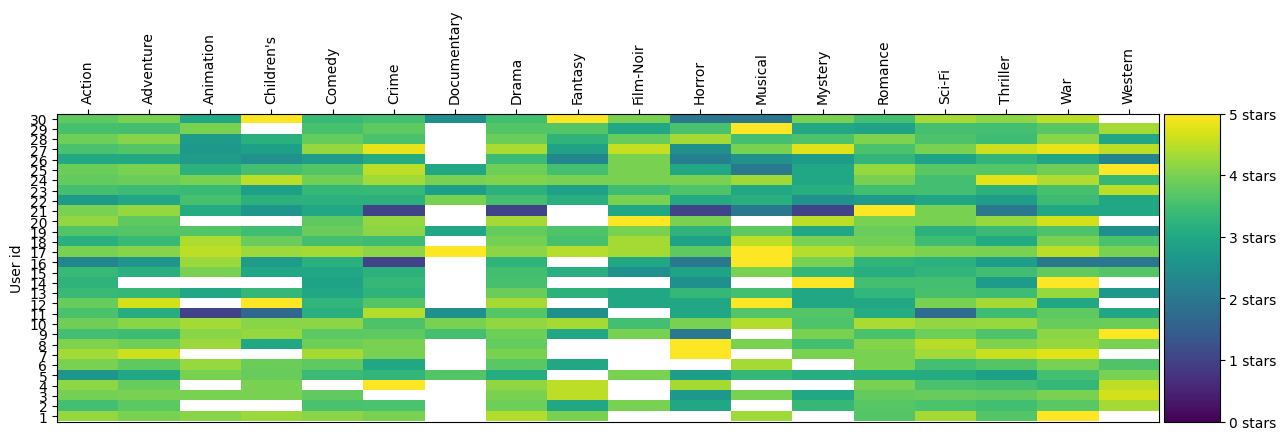

In [ ]:
draw_movies_heatmap(user_genre_ratings_selection)

In [ ]:
z=user_genre_ratings.replace(np.nan,0)
z


genre,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,4.20,4.00,4.11,4.25,4.14,4.00,0.00,4.43,4.00,0.00,0.00,4.29,0.00,3.67,4.33,3.67,5.00,0.00
2,3.50,3.74,0.00,0.00,3.56,3.58,0.00,3.90,3.00,4.00,3.00,0.00,3.33,3.71,3.59,3.48,3.73,4.33
3,3.96,4.00,4.00,4.00,3.77,0.00,0.00,4.00,4.50,0.00,2.67,4.00,3.00,3.80,3.83,3.80,4.00,4.67
4,4.16,3.83,0.00,4.00,0.00,5.00,0.00,4.17,4.50,0.00,4.33,0.00,0.00,4.00,3.56,3.50,3.33,4.50
5,2.61,3.00,4.00,3.83,3.41,3.29,3.67,3.10,0.00,4.00,2.80,3.33,3.12,3.10,3.07,2.85,3.50,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3.00,2.99,3.91,3.44,3.20,3.53,3.91,3.51,3.00,4.06,2.99,3.71,3.41,3.35,2.83,3.14,3.79,3.64
6037,3.64,4.00,4.00,3.67,3.58,3.83,4.00,3.88,4.25,3.44,4.11,4.00,3.69,3.68,3.69,3.71,4.00,3.75
6038,3.00,4.00,3.67,3.00,3.83,0.00,0.00,3.89,0.00,0.00,2.50,0.00,0.00,4.17,4.00,0.00,4.00,0.00


#elbow#

In [ ]:
possible_k_values = range(2, 1000)
#possible_k_values = range(2, len(x)+1, 5)
wcss = []

for i in possible_k_values:
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit(z)

  wcss.append(kmeans.inertia_)

In [ ]:
plt.plot(possible_k_values, wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

#k-menas ++ #

In [ ]:
kmeans = KMeans(n_clusters=150, init='k-means++', random_state=42,n_init=1)
predictions = kmeans.fit_predict(z)
print(predictions)

[118  18  19 ...  39  16  76]


In [ ]:
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        #d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        d = clustered[clustered.group == cluster_id].drop(['index'], axis=1)
        n_users_in_cluster = d.shape[0]

        d = sort_by_rating_density(d, max_movies, max_users)

        d = d.reindex(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]

        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)

            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('genres')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off')
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()
            # Let's only show 5 clusters
            c = c+1
            if c > 6:
                break





<ipython-input-13-16070d61c59d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 118
# of users in cluster: 35. # of users in plot: 35


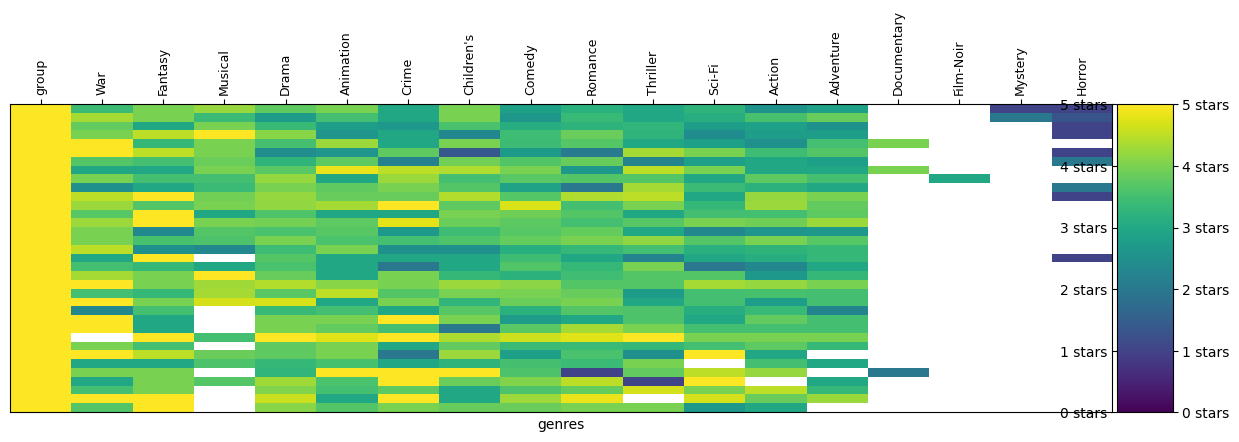

<ipython-input-13-16070d61c59d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 18
# of users in cluster: 40. # of users in plot: 40


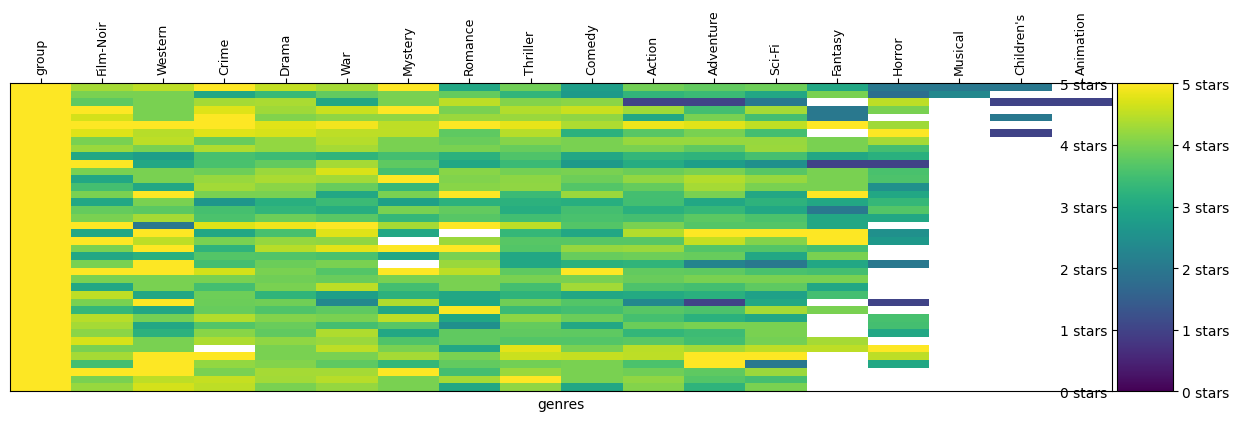

<ipython-input-13-16070d61c59d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 19
# of users in cluster: 67. # of users in plot: 67


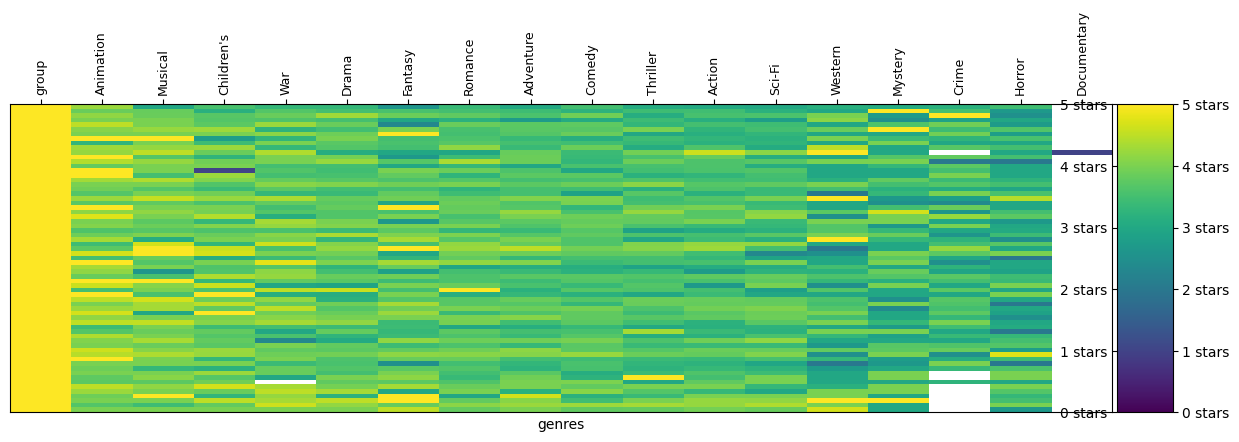

<ipython-input-13-16070d61c59d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 90
# of users in cluster: 20. # of users in plot: 20


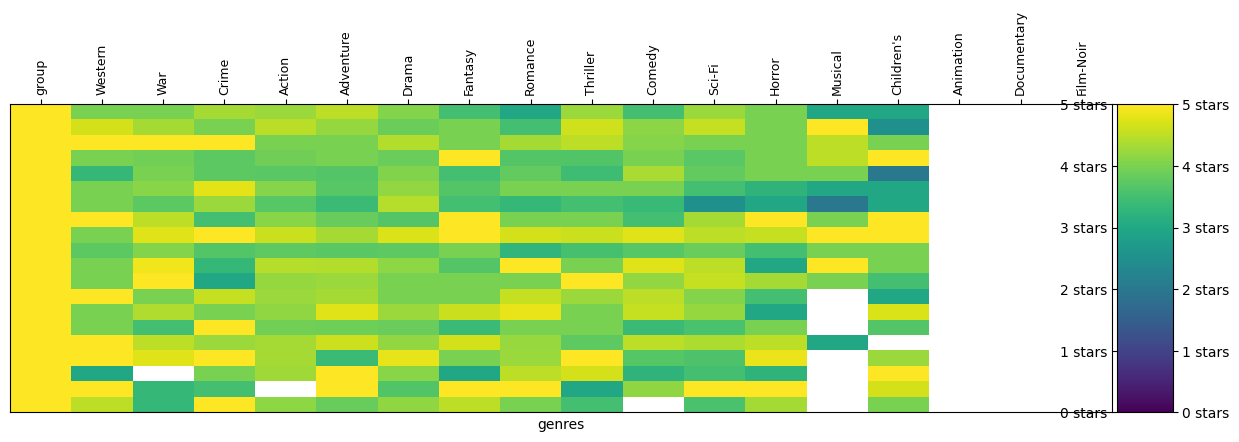

<ipython-input-13-16070d61c59d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 35
# of users in cluster: 17. # of users in plot: 17


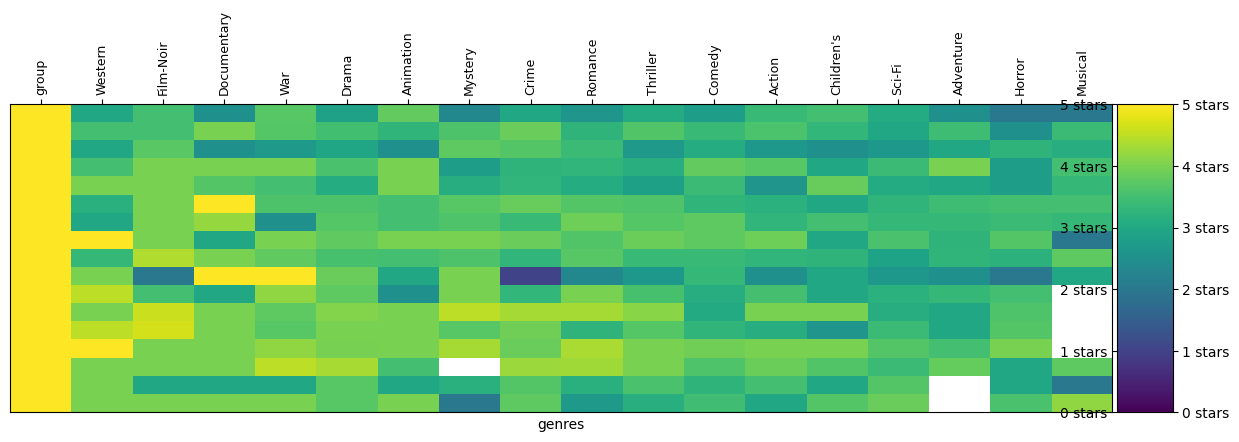

<ipython-input-13-16070d61c59d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 82
# of users in cluster: 24. # of users in plot: 24


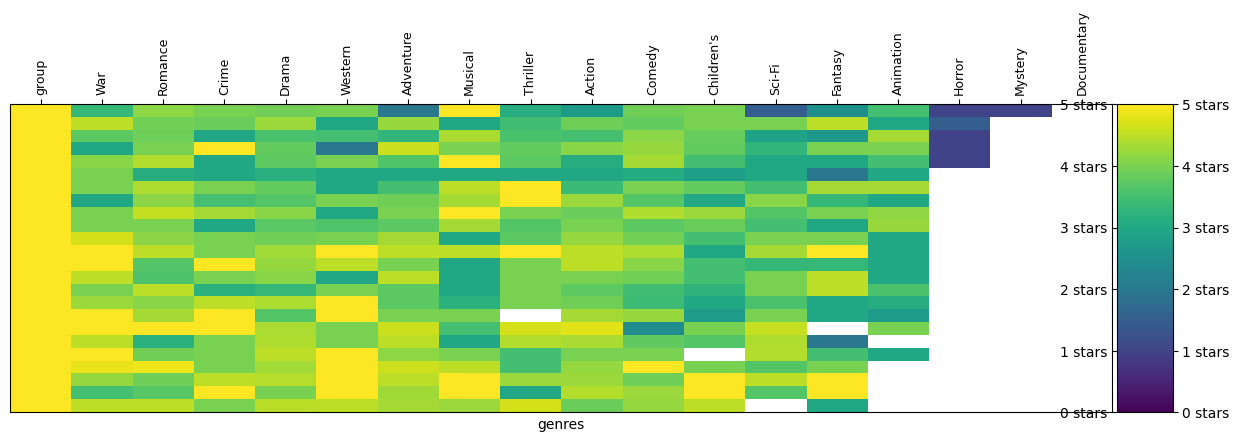

In [ ]:
user_genre_ratings.index.name='index'
max_users = 75
max_genres = 18

clustered = pd.concat([user_genre_ratings.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_genres)

In [ ]:
type(clustered)

pandas.core.frame.DataFrame

In [ ]:
print(clustered[clustered.group == 0].shape)
print(clustered[clustered.group == 1].shape)

(26, 20)
(100, 20)


#Random#

In [ ]:
kmeans = KMeans(n_clusters=150, init='random', random_state=42,algorithm='elkan',n_init=10)
pred2 = kmeans.fit_predict(z)
print(pred2)

In [ ]:
max_users = 30
max_genres = 18

clusteredR = pd.concat([user_genre_ratings.reset_index(), pd.DataFrame({'group':pred2})], axis=1)
draw_movie_clusters(clusteredR, max_users, max_genres)

#silhouette_score#
###higher value of silhouette score incdicates better clustering###

In [ ]:
silhouette1 = silhouette_score(z, predictions)
silhouette2 = silhouette_score(z, pred2)
print("k-means++,LIod:",silhouette1)
print("random,Elkan:",silhouette2)

#prediction#

In [ ]:
# TODO: Pick a cluster ID from the clusters above
cluster_number = 18

# filter to only see the region of the dataset with the most number of values
n_users = 75
n_genres = 18
cluster0 = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)


cluster0 = sort_by_rating_density(cluster0, n_genres, n_users)


draw_movies_heatmap(cluster0, axis_labels=False)

In [ ]:
cluster0.fillna('').head(50)


In [ ]:

genre_name = "Fantasy"

cluster0[genre_name].mean()

#recomendation#

In [ ]:
# The average rating of 18 genre as rated by the users in the cluster
cluster0.mean().head(18)

In [ ]:
#user from kmeans++ cluster number 3612
user_id = 3612

# Get all this user's ratings
user_2_ratings  = cluster0.loc[user_id, :]

# Which genres did they not rate? (We don't want to recommend genres they've already rated)
user_2_unrated_genres =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these genres the user did not rate?
avg_ratings = pd.concat([user_2_unrated_genres, cluster0.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated genres are presented first
avg_ratings.sort_values(ascending=False)[:5]

#silhouette score over different percentages of database#

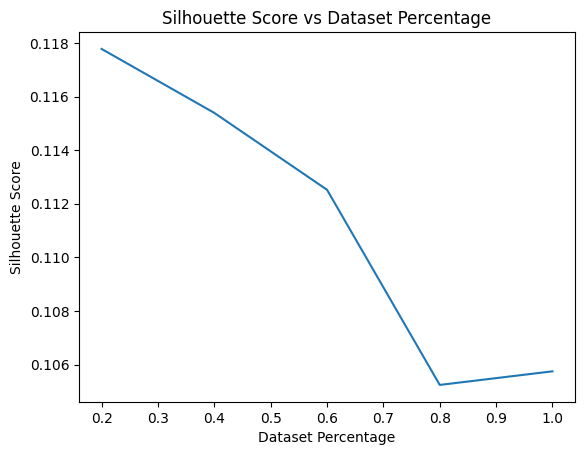

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming your dataset is stored in a variable called 'data'
# Split the dataset into different percentages
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
silhouette_scores = []

for percentage in percentages:
    # Calculate the number of samples based on the percentage
    num_samples = int(len(z) * percentage)

    # Select the required number of samples randomly
    sampled_data = z.sample(n=num_samples, random_state=42)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=150, init='k-means++', random_state=42, n_init=1)
    predictionss = kmeans.fit_predict(sampled_data)

    # Calculate the silhouette score
    silhouette = silhouette_score(sampled_data, predictionss)
    silhouette_scores.append(silhouette)

# Plotting the results
import matplotlib.pyplot as plt

plt.plot(percentages, silhouette_scores)
plt.title('Silhouette Score vs Dataset Percentage')
plt.xlabel('Dataset Percentage')
plt.ylabel('Silhouette Score')
plt.show()